Two Person Speaker Recognition
================

In [1]:
import os
import sys
import librosa
import tflearn
import pydub
import wave
import pickle
import speech_data
import segment_data
import tensorflow as tf
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
%matplotlib inline

hdf5 not supported (please install/reinstall h5py)


/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# load constants - training directory, testing directory
training_data = '/home/cc/Data/OCI-Full/'
training = '/home/cc/Data/test3/'
testing = '/home/cc/Data/test4/'

In [3]:
# load the sample file, play it back. Also show the graph of sample
y, fs = librosa.load('/home/cc/Voice-Identification/audio_samples/full/speaker_sample.wav')
IPython.display.Audio(data=y, rate=fs)

In [4]:
# load the sample file, play it back. Also show the graph of sample
y1, fs1 = librosa.load('/home/cc/Voice-Identification/audio_samples/full1/speaker2_sample.wav')
IPython.display.Audio(data=y1, rate=fs1)

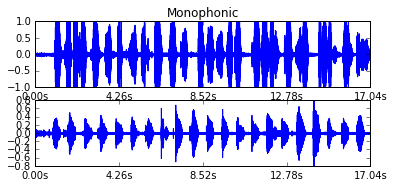

In [5]:
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=fs, max_points=50.0)
plt.title('Monophonic')
plt.subplot(3, 1, 2)
librosa.display.waveplot(y1, sr=fs1, max_points=50.0)
plt.show()

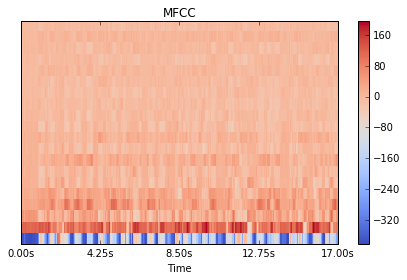

In [6]:
# perform mfcc calculation, display the result in graphic form
mfcc = librosa.feature.mfcc(y=y, sr=fs)
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

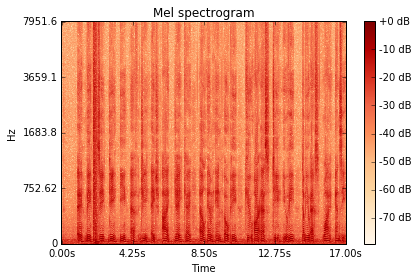

In [7]:
# additionally, display the mel-spectrogram of the audio file
m_spect = librosa.feature.melspectrogram(y=y, sr=fs)
D = librosa.stft(y)
S, phase = librosa.magphase(D)
components, activations = librosa.decompose.decompose(S, n_components=8, sort=True)
librosa.display.specshow(librosa.logamplitude(S, ref_power=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

In [8]:
# calculate the mfcc matrices for training from the segmented data
X = []
Y = []
speakers = speech_data.get_speakers(training)
for f in os.listdir(training):
    Y.append(speech_data.one_hot_from_item(speech_data.speaker(f), speakers))
    y, sr = librosa.load(training + f)
    X.append(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))

number of files: 88
(2, ' speakers: ', ['arun', 'andrew'])


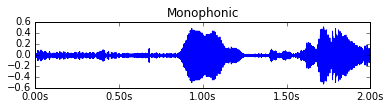

In [9]:
# use the segmented data to visualize in a different way
y_seg, sr_seg = librosa.load('/home/cc/Voice-Identification/audio_samples/segment/speaker2_0.wav')
mfcc_seg = librosa.feature.mfcc(y_seg, sr_seg, n_mfcc=20)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y_seg, sr=sr_seg)
plt.title('Monophonic')
plt.show()
IPython.display.Audio(data=y_seg, rate=sr_seg)

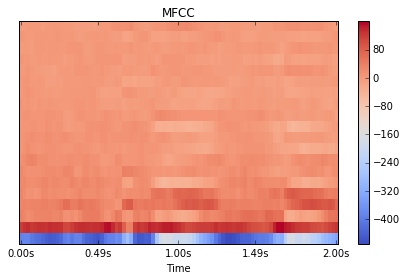

In [10]:
librosa.display.specshow(mfcc_seg, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [11]:
# define the network and the model for training
tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5)

net = tflearn.input_data(shape=[None, 20, 87])
net = tflearn.fully_connected(net, 36)
net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, len(speakers), activation='softmax')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

In [12]:
# now train the model!
model = tflearn.DNN(net)
model.fit(X, Y, n_epoch=1000, show_metric=True, snapshot_step=1000, run_id='SpeakerRec')

Training Step: 2000  | total loss: 1.13136
| Adam | epoch: 1000 | loss: 1.13136 - acc: 0.9212 -- iter: 88/88
Training Step: 2000  | total loss: 1.13136
| Adam | epoch: 1000 | loss: 1.13136 - acc: 0.9212 -- iter: 88/88
--


In [13]:
mfcc_seg = np.reshape(mfcc_seg, newshape=(1,20,87))

In [14]:
result = model.predict(mfcc_seg)

In [15]:
print(speech_data.one_hot_to_item(result, speakers))

arun


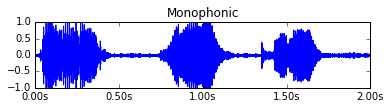

arun


In [16]:
# use the segmented data to visualize in a different way
y_seg, sr_seg = librosa.load('/home/cc/Voice-Identification/audio_samples/segment/speaker_3.wav')
mfcc_seg = librosa.feature.mfcc(y_seg, sr_seg, n_mfcc=20)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y_seg, sr=sr_seg)
plt.title('Monophonic')
plt.show()
IPython.display.Audio(data=y_seg, rate=sr_seg)
mfcc_seg = np.reshape(mfcc_seg, newshape=(1,20,87))
result = model.predict(mfcc_seg)
print(speech_data.one_hot_to_item(result, speakers))